### Spatial correlation for  all points

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree, BallTree
from sklearn.cluster import DBSCAN
import pickle
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

np.set_printoptions(edgeitems=30, linewidth=100000, 
                    formatter=dict(float=lambda x: "%14.7g" % x))

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [3]:
# Import of the time-series data and the location of all the points
locs = np.load('geographical_location.npy')
locsm = np.load('geographical_location_m.npy')
data_imp = pd.read_pickle('AmsData_measurements.pkl')
mydata = (data_imp.T * 1000).T
orig_x = np.load('orig_x.npy')

In [3]:
tree = KDTree(locsm)

In [4]:
# count the number of points
ts_nums = [x for x in range(locsm.shape[0])]

# distances and indices of six closest neighbours
dist_and_ind = [tree.query(locsm[i, :].reshape(1, 2), k = 6) for i in ts_nums]
dist = [dist_and_ind[i][0][0] for i in range(locsm.shape[0])]
inds = [dist_and_ind[i][1][0].astype(int) for i in range(locsm.shape[0])]

# indices and distances of the points that are closer than 10 meters
ind_and_dist_10 = [tree.query_radius(locsm[i, :].reshape(1, 2), r=10, count_only=False, return_distance=True, sort_results = True) for i in ts_nums]
inds_10 = [ind_and_dist_10[i][0][0] for i in range(locsm.shape[0])]
dist_10 = [ind_and_dist_10[i][1][0] for i in range(locsm.shape[0])]
# dist, ind = tree.query(locsm[ts_num,:].reshape(1, 2), k = 6)
# inds = [int(i) for i in ind[0]]
# print(inds_10)

In [4]:
def corr_from_clust(x, y, num=-1, plots=True):
    """
    input: 
    x - the original point (time series) as Series
    y - the point that is being compared to x (time series) as Series325
    
    return:
    correlation coefficients for two (one) largest clusters
    """
    points = np.vstack([x.values.T, y.values.T]).T
    
    db = DBSCAN(eps=2, min_samples=10, metric='euclidean')
    db.fit(points)
    labels = db.labels_
    y_db = db.fit_predict(points)
    
    if len(set(labels)) > 2:
        occur = []
        indices = list(set(labels)) - min(set(labels))
        for i in set(labels):
#             print(i)
            occur.append(list(labels).count(i))
#         print(occur)
#         print(list(set(labels)))
#         print(sorted(occur, reverse=True))
        max_index = [occur.index(num) for num in sorted(occur, reverse = True)[:2]]
        best_ind = [list(set(labels))[max_index[i]] for i in range(len(max_index))]
        
    else:
        best_ind = [0]
        
#     print('best_ind:', best_ind)
    

#     print("Slopes:", m)
#     print("Intersections:", b)

    coeffs_new = [np.corrcoef(points[y_db ==i,0], points[y_db ==i,1])[0][1] for i in range(len(best_ind))]
    if not coeffs_new:
        print("Empty! {}".format(num))
#     print("\nCorr. coefficients:", coeffs_new)
#     print("Mean of corr. coefficients:", np.mean(coeffs_new))
    
    if plots:
        m = []
        b = []
        for i in best_ind:
            slope, inters = np.polyfit(points[y_db ==i,0], points[y_db == i,1],1)
            m.append(slope)
            b.append(inters)

        plt.figure(figsize=(10,5))
    #     for i in set(labels):
        plt.scatter(points[:,0], points[:,1], s=30, c="lightgrey")
        for i in best_ind:
            plt.scatter(points[y_db ==i,0], points[y_db == i,1], s=30)
        for i, val in enumerate(best_ind):
            plt.scatter(points[y_db ==val,0], m[i]*points[y_db ==val,0] + b[i], s=5)

        plt.grid(True)
        plt.gca().set_axisbelow(True)
        if num == -1:
            plt.title('DBSCAN')
        else:
            plt.title('DBSCAN - {}'.format(num) )

        plt.show()
    
    return coeffs_new


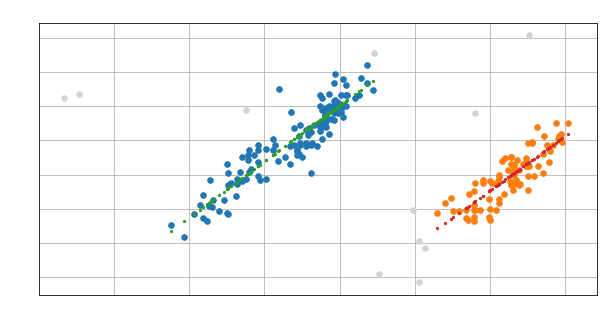

[0.8509233525561273, 0.9247772750335843]

In [5]:
corr_from_clust(mydata.iloc[325], mydata.iloc[324])

In [ ]:
mydata.iloc[ts_nums]

In [ ]:
for i in ts_nums:
    for j in inds[i]:
        

In [22]:
corr_np_all = []
corr_10_np_all = []
corr_dbscan_max = []
# corr_rol = []

corr_np_all = [np.corrcoef(mydata.iloc[inds[ts_nums[i]]]) for i in ts_nums]
corr_10_np_all = [(np.corrcoef(mydata.iloc[inds_10[ts_nums[i]]])) for i in ts_nums]
%time corr_dbscan_max = [[max(corr_from_clust(mydata.iloc[i], mydata.iloc[index], index, plots=False)) for index in inds[i]] for i in ts_nums]
%time corr_rol = [[mydata.iloc[i].rolling(30, center=True).corr(mydata.iloc[index]).median() for index in inds[i]] for i in ts_nums]

/home/ada/anaconda3/envs/outlierdet/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/ada/anaconda3/envs/outlierdet/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ada/anaconda3/envs/outlierdet/lib/python3.6/site-packages/numpy/lib/function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ada/anaconda3/envs/outlierdet/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ada/anaconda3/envs/outlierdet/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ada/anaconda3/envs/outlierdet/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeW

CPU times: user 3min 6s, sys: 84 ms, total: 3min 6s
Wall time: 3min 6s


In [26]:
corr_np[0]

array([             1,      0.9107585,      0.7088091,      0.5038823,      0.6356926,      0.2269517])

In [29]:
corr_rol[0]

[0.9999999999999997,
 0.8831648729100332,
 0.3859269598894959,
 0.48369160450759907,
 0.4000191381711995,
 0.296540931848438]

In [35]:
all_corrs = {i:[inds[i], corr_np[i], np.asarray(corr_dbscan_max[i]), np.asarray(corr_rol[i])] for i in ts_nums}

In [36]:
all_corrs

{0: [array([ 0,  5,  4,  3, 31, 21]),
  array([             1,      0.9107585,      0.7088091,      0.5038823,      0.6356926,      0.2269517]),
  array([             1,      0.9368909,      0.7496753,      0.5606921,      0.6449537,      0.2243583]),
  array([             1,      0.8831649,       0.385927,      0.4836916,      0.4000191,      0.2965409])],
 1: [array([ 1, 33, 29, 30, 32, 28]),
  array([             1,      0.9364172,      0.8127516,      0.6236066,       0.684995,      0.6289517]),
  array([             1,      0.9801151,      0.8878878,       0.740589,      0.7162626,      0.6390732]),
  array([             1,      0.7206956,      0.5251901,      0.3582256,      0.4640096,      0.5526127])],
 2: [array([ 2, 35, 39, 34, 38, 40]),
  array([             1,      0.9495201,      0.7248571,      0.9112742,      0.6899674,      0.9694954]),
  array([             1,      0.9900602,      0.9328113,      0.9567906,      0.8266877,      0.9734878]),
  array([             1,    

In [39]:
all_corrs_arr = {}
for i in ts_nums:
    all_corrs_arr[i] = np.vstack(all_corrs[i][1:])

In [56]:
all_corrs_one = {}
# 'values': maximum correlation value (out of 3 methods)
# 'method': which method provided the highest value, 0-whole signal, 1-DBSCAN, 2-sliding window
# 'index': indices of corresponding neighbours

for i in ts_nums:
    all_corrs_one[i] = {'values': np.max(all_corrs_arr[i], axis=0),
                        'method': np.argmax(all_corrs_arr[i], axis=0),
                        'index': inds[i]}


In [57]:
all_corrs_one

{0: {'values': array([             1,      0.9368909,      0.7496753,      0.5606921,      0.6449537,      0.2965409]),
  'method': array([1, 1, 1, 1, 1, 2]),
  'index': array([ 0,  5,  4,  3, 31, 21])},
 1: {'values': array([             1,      0.9801151,      0.8878878,       0.740589,      0.7162626,      0.6390732]),
  'method': array([2, 1, 1, 1, 1, 1]),
  'index': array([ 1, 33, 29, 30, 32, 28])},
 2: {'values': array([             1,      0.9900602,      0.9328113,      0.9567906,      0.8266877,      0.9734878]),
  'method': array([0, 1, 1, 1, 1, 1]),
  'index': array([ 2, 35, 39, 34, 38, 40])},
 3: {'values': array([             1,      0.5606921,      0.5144247,      0.5831461,      0.2961424,      0.2272897]),
  'method': array([0, 1, 1, 1, 0, 1]),
  'index': array([ 3,  0,  5,  4, 31, 21])},
 4: {'values': array([             1,      0.7496753,      0.7157697,      0.5831461,      0.6689213,      0.1801686]),
  'method': array([2, 1, 1, 1, 1, 1]),
  'index': array([ 4,  0,

In [59]:
with open('all_corrs.bin', 'wb') as file:
    pickle.dump(all_corrs_one, file)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(121)
im = ax1.imshow(corr_np[300], cmap='brg', interpolation='nearest')

ax2 = plt.subplot(122)
ax2.imshow(corr_10_np[300], cmap='brg', interpolation='nearest')
fig.colorbar(im, ax=ax2)
plt.show()



# for i in ts_num:
#     corr_np.append(np.corrcoef(mydata.iloc[inds[i]]))
#     print(corr_np)

In [ ]:
ts_num = 300
cor = []
for i in inds[ts_num]:
    c1 = np.corrcoef(mydata.iloc[ts_num], mydata.iloc[i])
    c2 = corr_from_clust(mydata.iloc[ts_num], mydata.iloc[i], i)
    c3 = mydata.iloc[ts_num].rolling(30, center=True).corr(mydata.iloc[i]).median()
    cor.append([c1[0,1], c2, c3])
    print("Correlation for the whole: {}\n" \
            "correlation form clusters: {}\n" \
            "rolling correlation: {:5f}".format(c1[0,1], c2, c3))


In [ ]:
# c1 = corr_np[300][0,:]
cor